## https://github.com/ankurhanda/nerf2D

In [1]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pytorch_lightning import Trainer, seed_everything

from fastai2.data.core import DataLoaders
from fastai2.vision.all import *

#%matplotlib inline
#from pytorch_lightning.core.lightning import Trainer, LightningModule

In [2]:
encoding="PosEnc"

In [3]:
!ls images

cool_cows.jpg  fractal.jpg  glasses.jpg  robot.jpg  salad.jpg


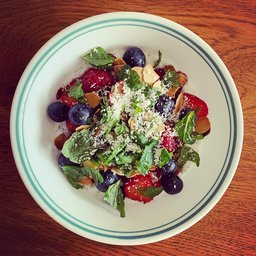

In [4]:
img_path = "images/salad.jpg"
pil_img = Image.open(img_path)
pil_img

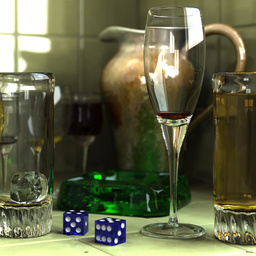

In [5]:
img_path = "images/glasses.jpg"
pil_img = Image.open(img_path)
pil_img

In [6]:
len = 200

# Data

In [7]:
feats = torch.empty(65536, 0)

for coords_data in [i_coord, j_coord]:
    for wave_fn in [torch.sin, torch.cos]:
        for freq_coef in [4,8]:
            feat = wave_fn(freq_coef*coords_data)
            print(feat.view(-1))
            
            feats = torch.cat((feats, feat.view(-1, 1)), dim=1)
            
            plt.imshow(feat.numpy())
            plt.show()

NameError: name 'i_coord' is not defined

In [11]:
"""
class ImageDataset(Dataset):

    def __init__(self, img_path):
        pil_img = Image.open(img_path)
        img_arr = np.array(pil_img)
        self.img_arr = img_arr / 255.0
        self.H, self.W, self.C = self.img_arr.shape
        self.i_values = torch.linspace(-1.0, 1.0 , self.H)
        self.j_values = torch.linspace(-1.0, 1.0 , self.W)

    def __len__(self):
        return self.H * self.W

    def __getitem__(self, idx):
        i = idx // self.W
        j = idx % self.W
        
        i_val = self.i_values[i] #j / self.W
        j_val = self.j_values[j] #i / self.H
        return (torch.tensor([i_val, j_val], dtype=torch.float),
                torch.tensor(self.img_arr[i,j]))
"""
class ImageDataset(Dataset):

    def __init__(self, img_path, encoding):
        
        # Read Image
        pil_img = Image.open(img_path)
        img_arr = np.array(pil_img)
        H, W, C = img_arr.shape
        
        # Save X (feats)
        if encoding=="CoordConv":
            self.n_feats = 2
            i_coord = torch.linspace(start=-1.0, end=1.0, steps=H).view(H, -1).expand(-1, W)
            j_coord = torch.linspace(start=-1.0, end=1.0, steps=W).view(-1, W).expand(H, -1)
            self.feats  = torch.stack([i_coord, j_coord], dim=2).view(-1, 2)
            
        if encoding=="PosEnc":
            self.n_feats = 16
            i_coord = torch.linspace(start=-1.0, end=1.0, steps=H).view(H, -1).expand(-1, W)
            j_coord = torch.linspace(start=-1.0, end=1.0, steps=W).view(-1, W).expand(H, -1)
            self.feats  = torch.empty(H*W, 0)

            for coords_data in [i_coord, j_coord]:
                for wave_fn in [torch.sin, torch.cos]:
                    for freq_coef in [2,4,8,16]:
                        feat = wave_fn(freq_coef*coords_data)
                        self.feats = torch.cat((self.feats, feat.view(-1, 1)), dim=1)

        
        # Save Y (rgb)
        img_arr = img_arr / 255.0
        self.rgb = torch.tensor(img_arr).view(-1,3)

    def __len__(self):
        return self.feats.shape[0]

    def __getitem__(self, idx):
        return self.feats[idx], self.rgb[idx]

In [12]:
ds_salad   = ImageDataset("images/salad.jpg", encoding)
ds_glasses = ImageDataset("images/glasses.jpg", encoding)

In [13]:
ds_salad[0]

(tensor([-0.9093,  0.7568, -0.9894,  0.2879, -0.4161, -0.6536, -0.1455, -0.9577,
         -0.9093,  0.7568, -0.9894,  0.2879, -0.4161, -0.6536, -0.1455, -0.9577]),
 tensor([0.2980, 0.1059, 0.1176], dtype=torch.float64))

# Model

In [14]:
if encoding=="CoordConv": input=2;
if encoding=="PosEnc":    input=16;
hidden=256; output=3

model = nn.Sequential(
    nn.Linear(input, hidden), nn.ReLU(),
    nn.Linear(hidden,hidden), nn.ReLU(),
    nn.Linear(hidden,hidden), nn.ReLU(),
    nn.Linear(hidden,hidden), nn.ReLU(),
    nn.Linear(hidden,output))
model

Sequential(
  (0): Linear(in_features=16, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=3, bias=True)
)

# Train

In [ ]:
dl_salad    = DataLoaders.from_dsets(ds_salad,   ds_salad,   bs=32, device="cuda")
dl_glasses  = DataLoaders.from_dsets(ds_glasses, ds_glasses, bs=32, device="cuda")

learn = Learner(dls       = dl_glasses,
                model     = model,
                loss_func = MSELossFlat(),
                #metrics   = [F1Score(average='macro'), accuracy],
                cbs       = [ShowGraphCallback()])
#learn.model.cuda()

learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,time
0,0.033729,0.036208,00:11
1,0.034381,0.032654,00:11
2,0.033493,0.031675,00:11
3,0.029997,0.030193,00:11
4,0.029400,0.029856,00:11
5,0.030876,0.029460,00:11
6,0.031004,0.029233,00:11
7,0.029296,0.028378,00:11
8,0.026104,0.028295,00:11
9,0.029530,0.027577,00:11


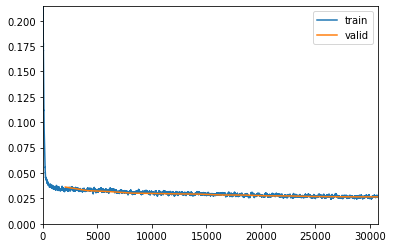

In [12]:
dl_salad    = DataLoaders.from_dsets(ds_salad,   ds_salad,   bs=32, device="cuda")
dl_glasses  = DataLoaders.from_dsets(ds_glasses, ds_glasses, bs=32, device="cuda")

learn = Learner(dls       = dl_glasses,
                model     = model,
                loss_func = MSELossFlat(),
                #metrics   = [F1Score(average='macro'), accuracy],
                cbs       = [ShowGraphCallback()])
#learn.model.cuda()

learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,time
0,0.023573,0.024076,00:12
1,0.020846,0.019449,00:11
2,0.021006,0.018784,00:11
3,0.016312,0.016903,00:12
4,0.015349,0.014070,00:11
5,0.014341,0.014738,00:12
6,0.011392,0.013104,00:12
7,0.011480,0.011654,00:12
8,0.010128,0.011302,00:11
9,0.009590,0.009842,00:11


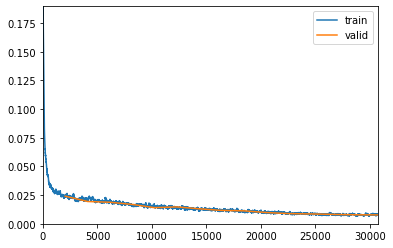

In [10]:
dl_salad    = DataLoaders.from_dsets(ds_salad,   ds_salad,   bs=32, device="cuda")
dl_glasses  = DataLoaders.from_dsets(ds_glasses, ds_glasses, bs=32, device="cuda")

learn = Learner(dls       = dl_glasses,
                model     = model,
                loss_func = MSELossFlat(),
                #metrics   = [F1Score(average='macro'), accuracy],
                cbs       = [ShowGraphCallback()])
#learn.model.cuda()

learn.fit_one_cycle(15)

# Inference

In [13]:
H,W = 256,256

In [15]:
learn.model.cpu()
rgbs = learn.model(ds_glasses.feats).view(H, W, 3).data.numpy()
#rgbs

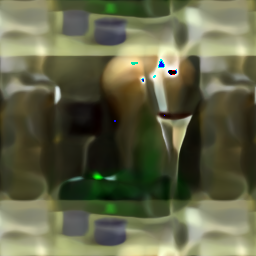

In [16]:
# 15 epochs pos enc
im = Image.fromarray(np.uint8(rgbs*255))
im

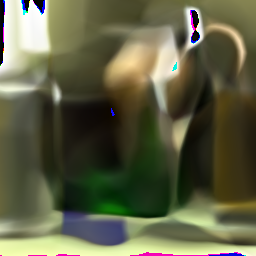

In [24]:
# 15 epochs
im = Image.fromarray(np.uint8(rgbs*255))
im

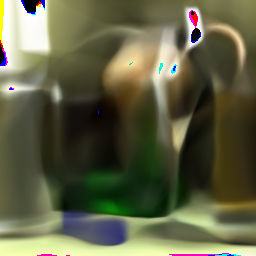

In [13]:
# 15 epochs
im = Image.fromarray(np.uint8(rgbs*255))
im

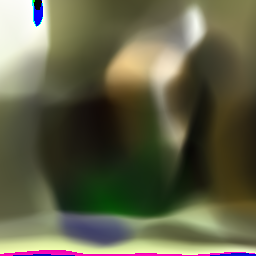

In [13]:
# 3 epochs
im = Image.fromarray(np.uint8(rgbs*255))
im

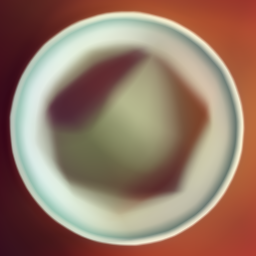

In [13]:
im = Image.fromarray(np.uint8(rgbs*255))
im